# Unpacking SQLite File
Based on [this tutorial](https://python.plainenglish.io/exploring-openstreetmap-data-using-geopandas-d62b55fc40a4).

In [1]:
import sqlite3
import geopandas as gpd
import pandas as pd
from shapely import wkt


In [4]:
# connect to tiles
DATA = "../data/south-africa-latest.sqlite"
con = sqlite3.connect(DATA)
cursor = con.cursor()
# inspect the result
query = """ SELECT name FROM sqlite_master WHERE type ='table' AND name NOT LIKE 'sqlite_%'; """
tables = cursor.execute(query)
tables.fetchall()

[('geometry_columns',),
 ('spatial_ref_sys',),
 ('points',),
 ('lines',),
 ('multilinestrings',),
 ('multipolygons',),
 ('other_relations',)]

In [5]:
geometry_columns = pd.read_sql("SELECT * FROM geometry_columns;", con) 
geometry_columns


,f_table_name,f_geometry_column,geometry_type,coord_dimension,srid,geometry_format
0,points,WKT_GEOMETRY,1,2,4326,WKT
1,lines,WKT_GEOMETRY,2,2,4326,WKT
2,multilinestrings,WKT_GEOMETRY,5,2,4326,WKT
3,multipolygons,WKT_GEOMETRY,6,2,4326,WKT
4,other_relations,WKT_GEOMETRY,7,2,4326,WKT


In [6]:
spatial_ref_sys = pd.read_sql("SELECT * FROM spatial_ref_sys;", con) 
spatial_ref_sys


,srid,auth_name,auth_srid,srtext
0,4326,EPSG,4326,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS..."


In [10]:
# get all geometries into one dataframe 
complete_df = pd.DataFrame() 

for geom_type in ['lines', 'points', 'multilinestrings', 'multipolygons', 'other_relations']: 
    df = pd.read_sql(f"SELECT *, '{geom_type}' AS table_name FROM {geom_type};", con) 
    complete_df = pd.concat([complete_df, df], ignore_index=True)


In [11]:
complete_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36726 entries, 0 to 36725
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ogc_fid       36726 non-null  object
 1   WKT_GEOMETRY  36726 non-null  object
 2   osm_id        36726 non-null  object
 3   name          13429 non-null  object
 4   highway       15047 non-null  object
 5   waterway      0 non-null      object
 6   aerialway     0 non-null      object
 7   barrier       1116 non-null   object
 8   man_made      44 non-null     object
 9   railway       0 non-null      object
 10  z_order       0 non-null      object
 11  other_tags    27303 non-null  object
 12  table_name    36726 non-null  object
 13  ref           1122 non-null   object
 14  address       0 non-null      object
 15  is_in         6263 non-null   object
 16  place         5386 non-null   object
 17  type          0 non-null      object
 18  osm_way_id    0 non-null      object
 19  aero

In [12]:
# convert dataframe into geodataframe 
complete_df['geom'] = gpd.GeoSeries.from_wkt(complete_df['WKT_GEOMETRY']) 
gdf = gpd.GeoDataFrame(complete_df, geometry='geom') 
gdf.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36726 entries, 0 to 36725
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ogc_fid       36726 non-null  object  
 1   WKT_GEOMETRY  36726 non-null  object  
 2   osm_id        36726 non-null  object  
 3   name          13429 non-null  object  
 4   highway       15047 non-null  object  
 5   waterway      0 non-null      object  
 6   aerialway     0 non-null      object  
 7   barrier       1116 non-null   object  
 8   man_made      44 non-null     object  
 9   railway       0 non-null      object  
 10  z_order       0 non-null      object  
 11  other_tags    27303 non-null  object  
 12  table_name    36726 non-null  object  
 13  ref           1122 non-null   object  
 14  address       0 non-null      object  
 15  is_in         6263 non-null   object  
 16  place         5386 non-null   object  
 17  type          0 non-null      object  
 18

<Axes: >

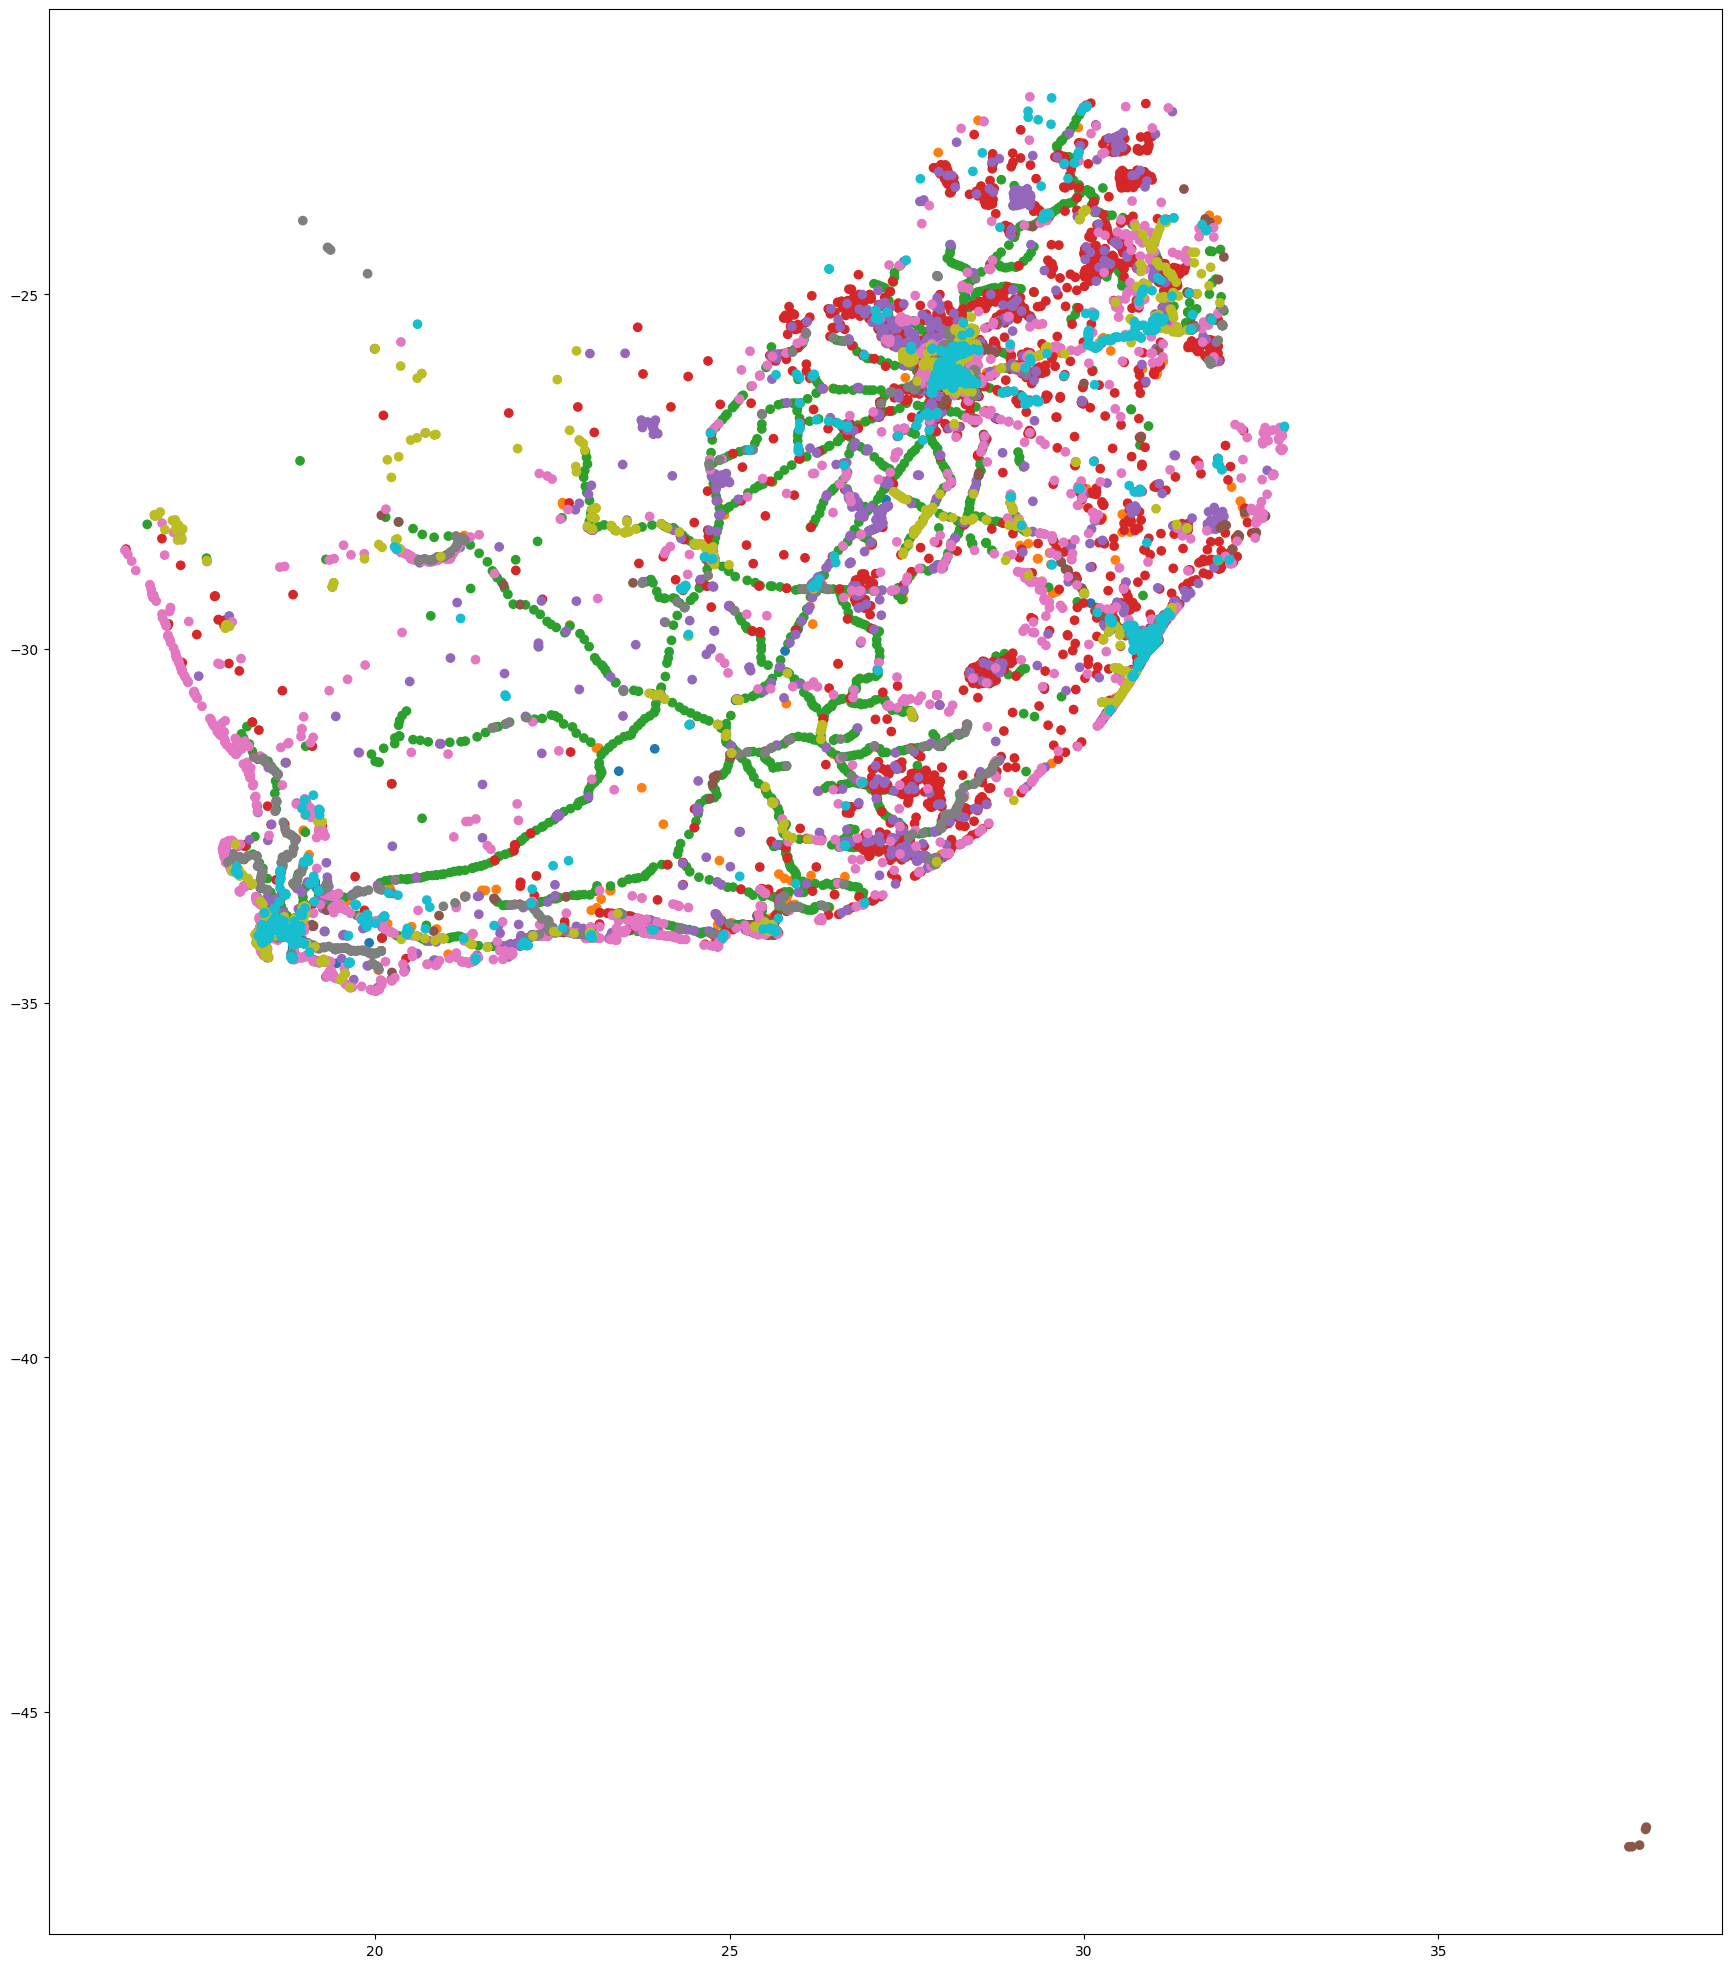

In [13]:
# Plotting all our data
gdf.plot(figsize=(25,25), column='ogc_fid')

<Axes: >

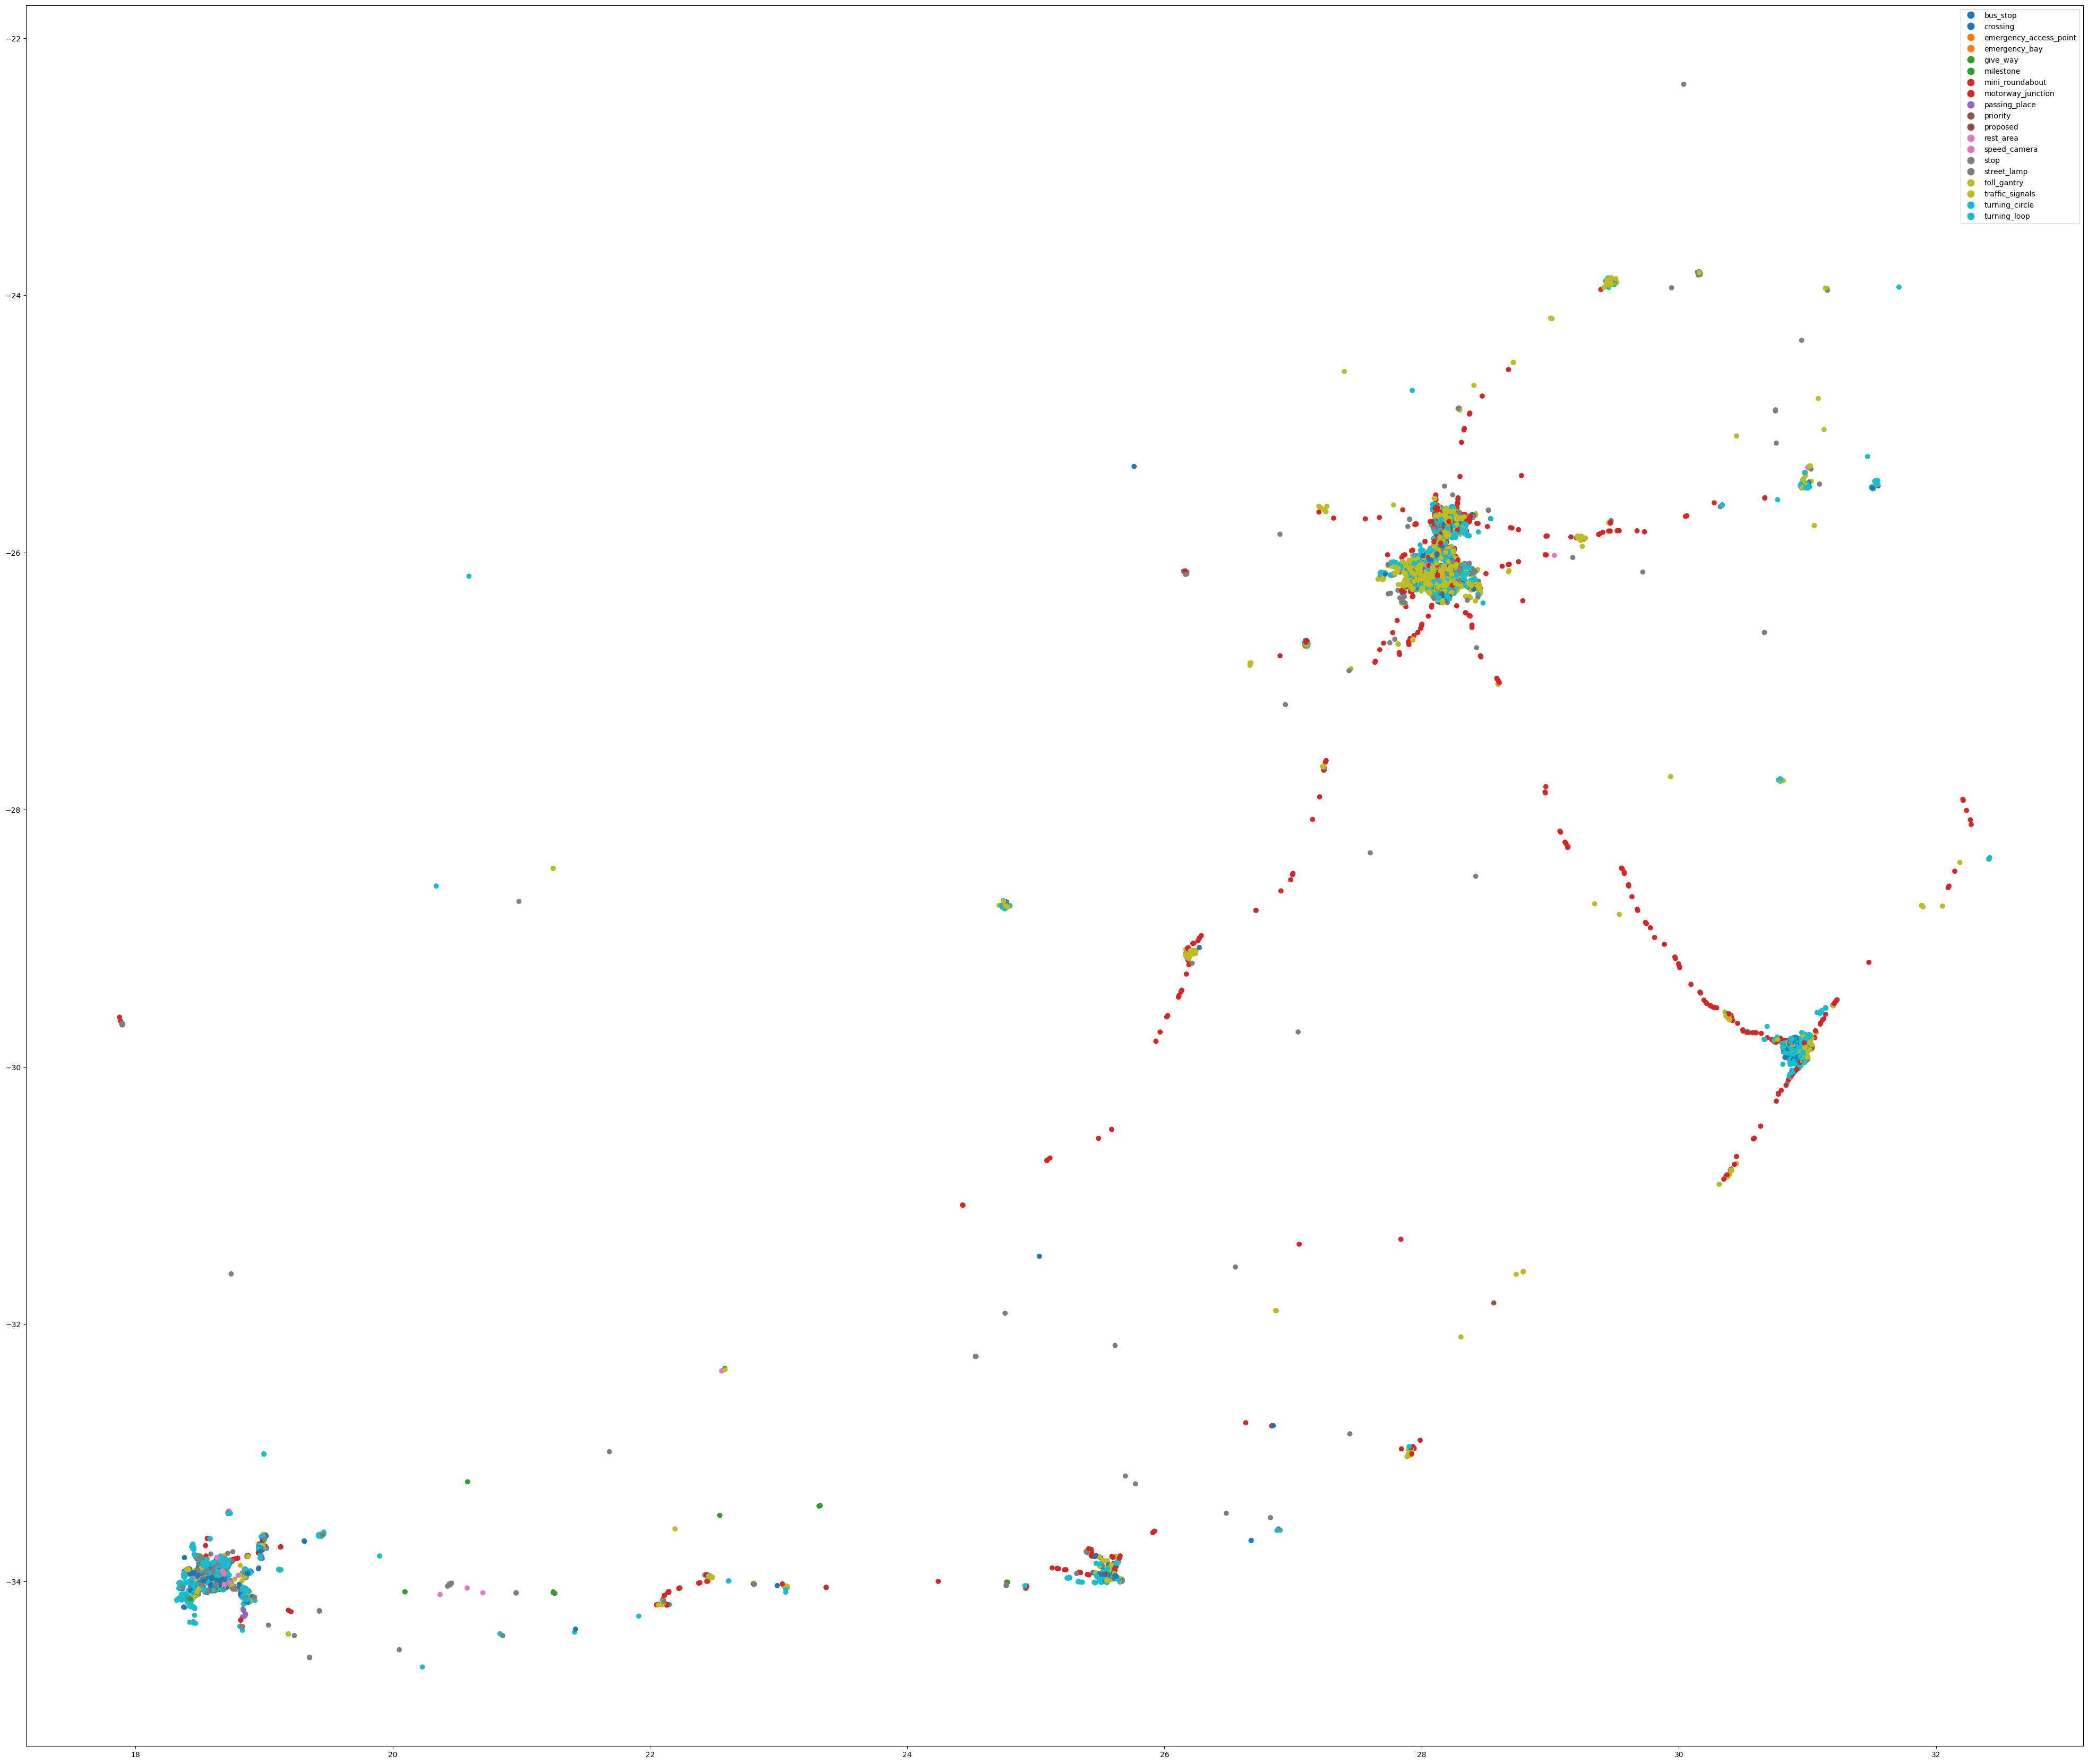

In [14]:
# viewing landuse
condition = gdf['highway'].notnull()
gdf[condition].plot(figsize=(50,50), column="highway", legend=True)

## Rather trying pyosmium

In [ ]:
import osmium


class StreetLookUp(osmium.SimpleHandler):
    def __init__(self):
        super(StreetLookUp, self).__init__()
        self.streets = []

    def node(self, o):
        if 'highway' in o.tags:
            self.streets.append(o.tags['name'])


h = StreetLookUp()
h.apply_file("../data/tileset/south-africa-latest.osm.pbf")

print(len(h.streets))

{direction=both,highway=stop,junction=t_junction...}
{highway=stop}
{highway=stop,stop=all,traffic_calming=table}
{highway=stop}
{crossing=uncontrolled,highway=crossing}
{crossing=traffic_signals,highway=crossing}
{highway=traffic_signals,traffic_signals:directi...}
{crossing=traffic_signals,highway=traffic_signals}
{highway=stop}
{highway=stop}
{highway=stop}
{highway=traffic_signals}
{highway=stop}
{highway=stop}
{highway=traffic_signals}
{highway=stop}
{highway=traffic_signals}
{highway=traffic_signals}
{highway=stop}
{highway=stop}
{highway=stop}
{highway=stop}
{highway=traffic_signals}
{direction=clockwise,highway=mini_roundabout}
{direction=clockwise,highway=mini_roundabout}
{highway=stop}
{highway=traffic_signals}
{crossing=traffic_signals,highway=traffic_signals}
{highway=traffic_signals}
{highway=traffic_signals}
{crossing=traffic_signals,highway=traffic_signals}
{highway=crossing}
{highway=crossing}
{highway=traffic_signals}
{highway=stop}
{highway=traffic_signals}
{direction

In [12]:
h.streets

['M10 Stanford Road',
 'R75 Commercial Road',
 'M3 New Brighton Beach',
 'R102 Cape Road',
 'Disa Avenue',
 'Darling Street',
 'Framesby',
 'Disa Avenue',
 'R75 Commercial Road',
 'M5 Mount Road',
 'M7 Albany Road',
 'M3 New Brighton Beach',
 'R512 Malibongwe Drive',
 'Buccleuch Interchange',
 'Buccleuch Interchange',
 'Buccleuch Interchange',
 'Olifantsfontein',
 '119A Edenvale',
 '119B Johannesburg',
 'Rand Airport Road',
 'N12',
 'Rand Airport Interchange',
 'Germiston',
 'Germiston',
 'Germiston',
 'Lenasia;Nigel',
 'Heidelberg North',
 'Heidelberg Centre',
 'Samrand Road',
 'M9 Rivonia Road',
 'Sandton',
 'R512 Malibongwe Drive',
 'R331 Hankey',
 'Flying Saucer Interchange',
 'Proefplaas Interchange',
 'R511 Sandton',
 'M5 Honeydew',
 'Jean Avenue',
 'Brakfontein Road',
 'Samrand Avenue',
 'Brakfontein Interchange',
 'Brakfontein Interchange',
 'Brakfontein Interchange',
 'Brakfontein Interchange',
 'Brakfontein Interchange',
 'Flying Saucer Interchange',
 'Proefplaas Interchange'